<a href="https://colab.research.google.com/github/mmsamiei/lets-pytorch/blob/master/Q7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
CUDA = True
BATCH_SIZE = 64

In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
# [CHANGED] Add dropout layer to introduce diversity in gradients
# [CHANGED] [Important] Use LeakyReLU since it keeps gradients better

discriminator = nn.Sequential(
    nn.Dropout(),
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 64),
    nn.Dropout(),
    nn.LeakyReLU(0.2),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

In [0]:
# [CHANGED] [Important] Use LeakyReLU since it keeps noise better
generator = nn.Sequential(
    nn.Linear(128, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 784),
    nn.Sigmoid()
)

In [0]:
if CUDA:
  discriminator.cuda()
  generator.cuda()

In [0]:
LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [0]:
N_EPOCH = 100

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3) # set default size of plots

epoch: 0 	 last batch loss D: 0.4311375021934509 	 last batch loss G: 5.00866174697876


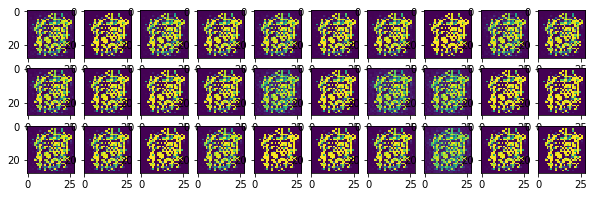

epoch: 10 	 last batch loss D: 0.3139621317386627 	 last batch loss G: 3.1576828956604004


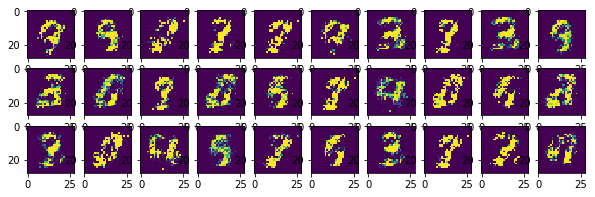

epoch: 20 	 last batch loss D: 0.49400851130485535 	 last batch loss G: 2.255506992340088


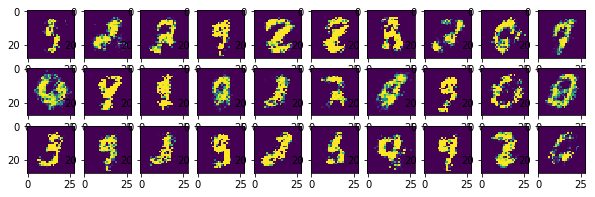

epoch: 30 	 last batch loss D: 1.2467403411865234 	 last batch loss G: 1.4971836805343628


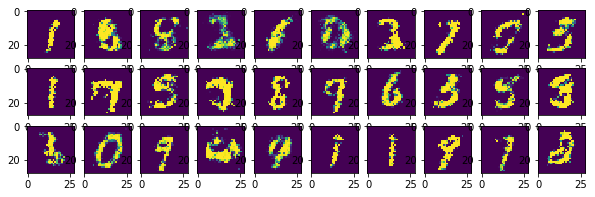

epoch: 40 	 last batch loss D: 0.9787778854370117 	 last batch loss G: 1.0728471279144287


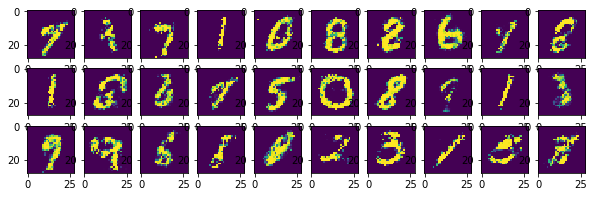

epoch: 50 	 last batch loss D: 1.0442514419555664 	 last batch loss G: 1.080108642578125


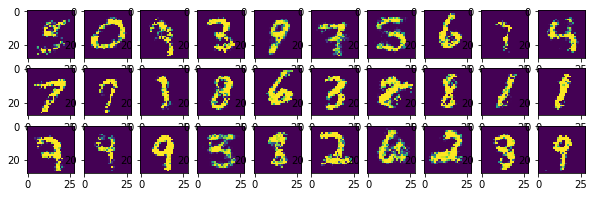

epoch: 60 	 last batch loss D: 1.3128571510314941 	 last batch loss G: 1.0911750793457031


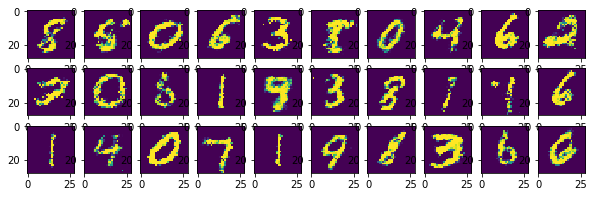

epoch: 70 	 last batch loss D: 1.2096043825149536 	 last batch loss G: 1.0753616094589233


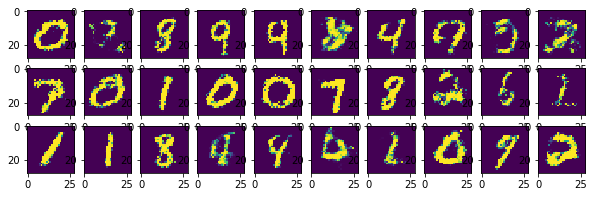

epoch: 80 	 last batch loss D: 1.2621488571166992 	 last batch loss G: 0.899268627166748


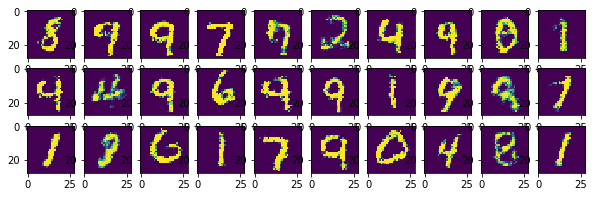

epoch: 90 	 last batch loss D: 1.2246959209442139 	 last batch loss G: 0.8262304663658142


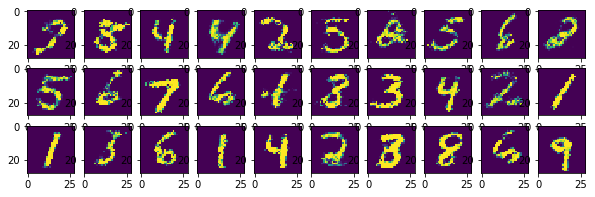

In [59]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.randn(img.shape[0], 128)
        #z = torch.rand(img.shape[0], 128) * 2 - 1
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        
        z = torch.randn(img.shape[0], 128)
        #z = torch.rand(img.shape[0], 128) * 2 - 1
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())
    
    if epoch%10 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()


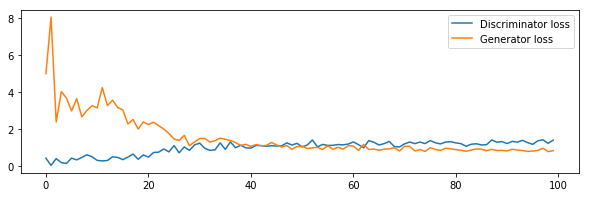

In [66]:
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.legend()
plt.show()

In [0]:
def reset_DG():
  for m in discriminator:
    if(len(m._parameters)>0):
      m.reset_parameters()
  for m in generator:
    if(len(m._parameters)>0):
      m.reset_parameters()
reset_DG()

epoch: 0 	 last batch loss D: 0.006502021104097366 	 last batch loss G: 7.71711540222168


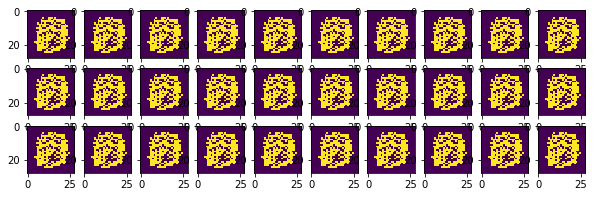

epoch: 10 	 last batch loss D: 4.481756150198635e-06 	 last batch loss G: 21.446819305419922


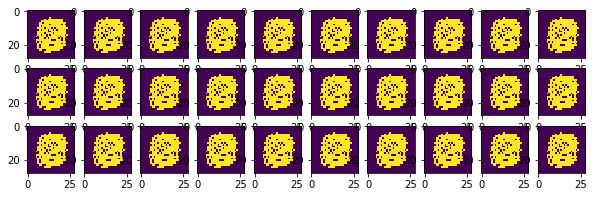

epoch: 20 	 last batch loss D: 4.787032708009065e-07 	 last batch loss G: 24.384841918945312


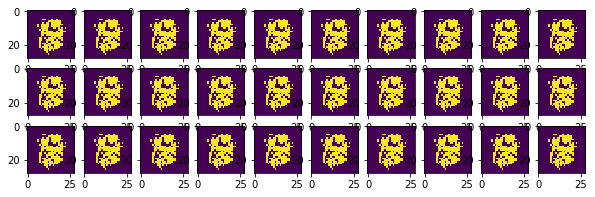

epoch: 30 	 last batch loss D: 0.0 	 last batch loss G: 31.864974975585938


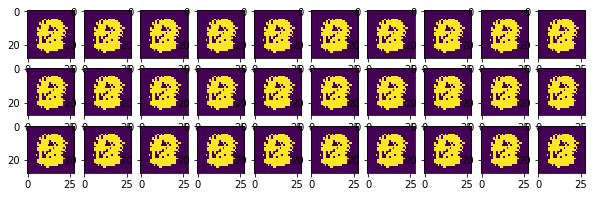

epoch: 40 	 last batch loss D: 8.56817976568891e-08 	 last batch loss G: 27.784238815307617


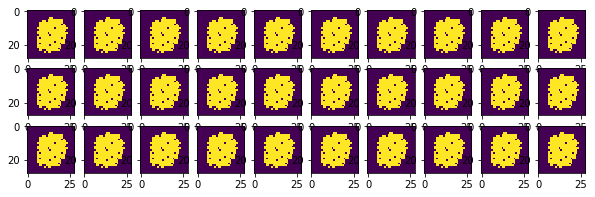

epoch: 50 	 last batch loss D: 7.30164742890338e-07 	 last batch loss G: 21.909481048583984


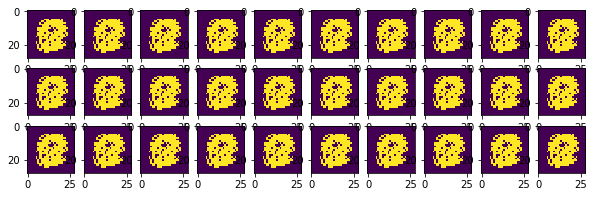

epoch: 60 	 last batch loss D: 0.0 	 last batch loss G: 32.74750518798828


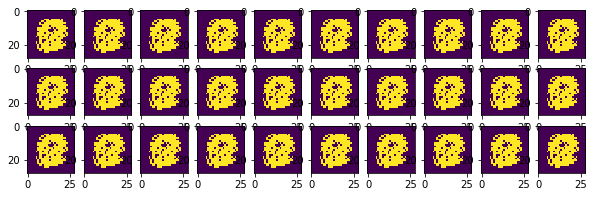

epoch: 70 	 last batch loss D: 0.0 	 last batch loss G: 38.18824768066406


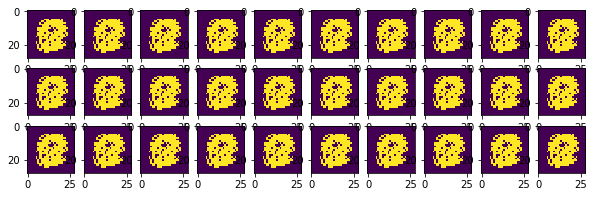

epoch: 80 	 last batch loss D: 0.0 	 last batch loss G: 44.8067626953125


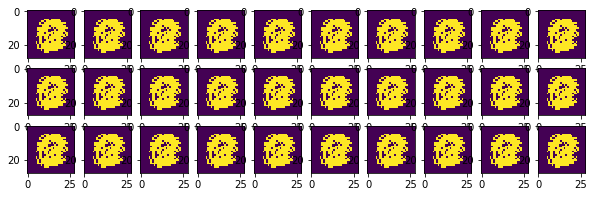

epoch: 90 	 last batch loss D: 0.0 	 last batch loss G: 42.54866027832031


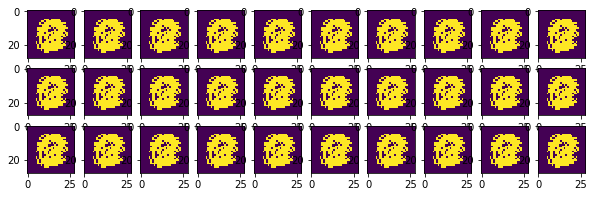

In [68]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6
d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128)
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.rand(img.shape[0], 128)
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################
    
    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())
    
    if epoch%10 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()


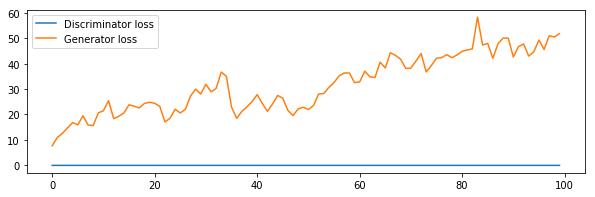

In [69]:
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.legend()
plt.show()

In [0]:
def reset_DG():
  for m in discriminator:
    if(len(m._parameters)>0):
      m.reset_parameters()
  for m in generator:
    if(len(m._parameters)>0):
      m.reset_parameters()
reset_DG()

epoch: 0 	 last batch loss D: 0.8320705890655518 	 last batch loss G: 1.8413231372833252


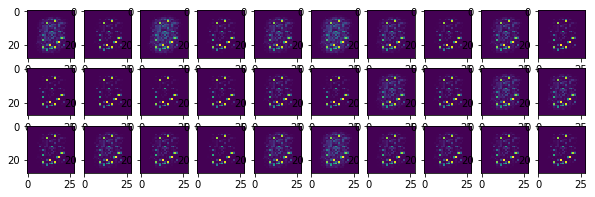

epoch: 10 	 last batch loss D: 0.18056724965572357 	 last batch loss G: 2.8040990829467773


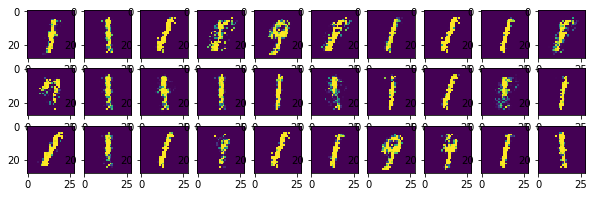

epoch: 20 	 last batch loss D: 0.5344155430793762 	 last batch loss G: 2.4704511165618896


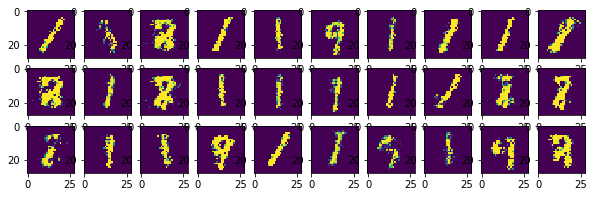

epoch: 30 	 last batch loss D: 0.6883732080459595 	 last batch loss G: 1.8338541984558105


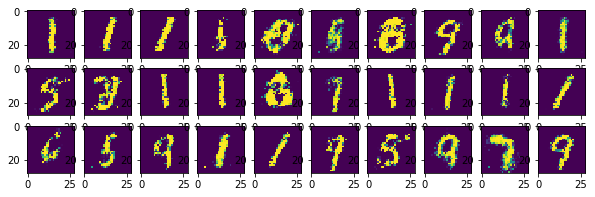

epoch: 40 	 last batch loss D: 1.0190701484680176 	 last batch loss G: 1.543440580368042


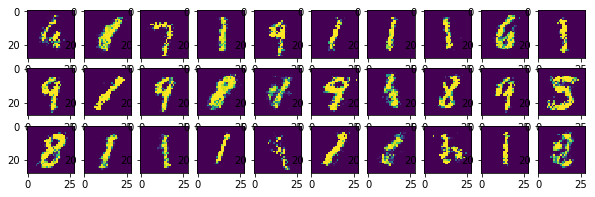

epoch: 50 	 last batch loss D: 1.1178996562957764 	 last batch loss G: 1.2578610181808472


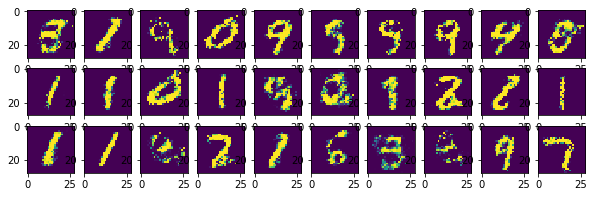

epoch: 60 	 last batch loss D: 0.90952068567276 	 last batch loss G: 1.4388790130615234


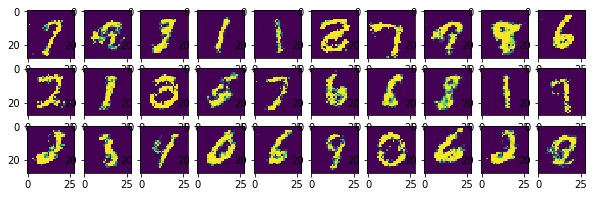

epoch: 70 	 last batch loss D: 0.9866750836372375 	 last batch loss G: 1.2347973585128784


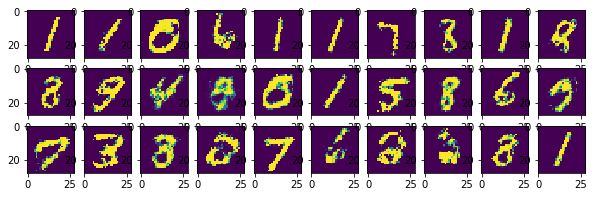

epoch: 80 	 last batch loss D: 1.0832575559616089 	 last batch loss G: 1.112493634223938


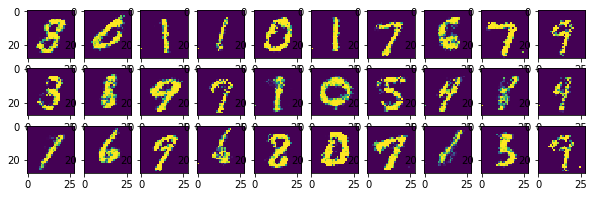

epoch: 90 	 last batch loss D: 1.1749041080474854 	 last batch loss G: 1.065692663192749


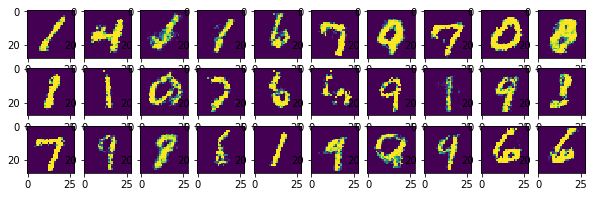

In [78]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128) * 1 - 0.5
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.rand(img.shape[0], 128) * 1 - 0.5
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################
    
    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())
        
    if epoch%10 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()


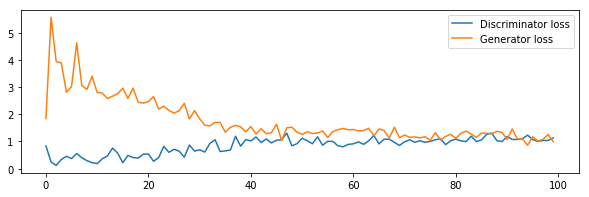

In [79]:
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.legend()
plt.show()

In [0]:
def reset_DG():
  for m in discriminator:
    if(len(m._parameters)>0):
      m.reset_parameters()
  for m in generator:
    if(len(m._parameters)>0):
      m.reset_parameters()
reset_DG()

epoch: 0 	 last batch loss D: 0.004240982234477997 	 last batch loss G: 10.737096786499023


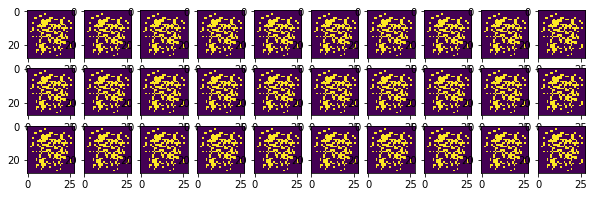

epoch: 10 	 last batch loss D: 6.239888534764759e-07 	 last batch loss G: 22.139598846435547


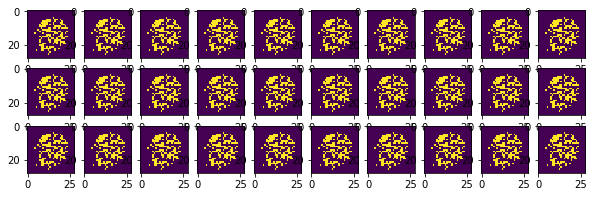

epoch: 20 	 last batch loss D: 0.00013839753228239715 	 last batch loss G: 16.066009521484375


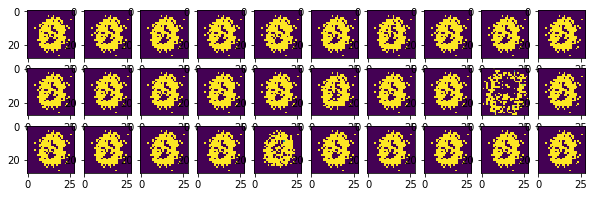

epoch: 30 	 last batch loss D: 0.0002931699273176491 	 last batch loss G: 13.204307556152344


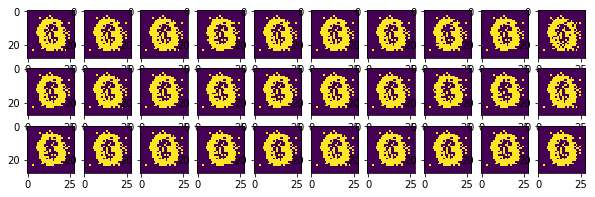

epoch: 40 	 last batch loss D: 0.000518888933584094 	 last batch loss G: 16.558135986328125


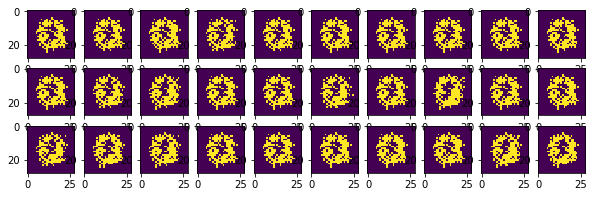

epoch: 50 	 last batch loss D: 0.0022295464295893908 	 last batch loss G: 17.30406379699707


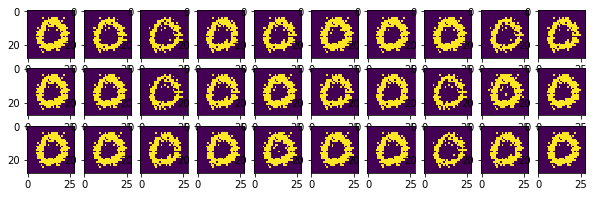

epoch: 60 	 last batch loss D: 1.6196738215512596e-05 	 last batch loss G: 16.04310417175293


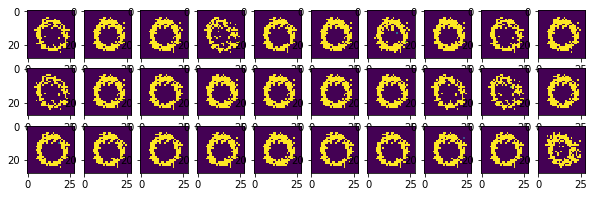

epoch: 70 	 last batch loss D: 9.05295200936962e-06 	 last batch loss G: 20.834754943847656


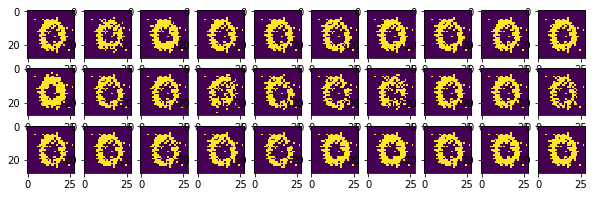

epoch: 80 	 last batch loss D: 0.0080020846799016 	 last batch loss G: 12.008127212524414


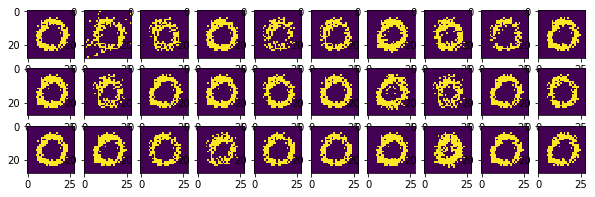

epoch: 90 	 last batch loss D: 0.006000841967761517 	 last batch loss G: 10.228209495544434


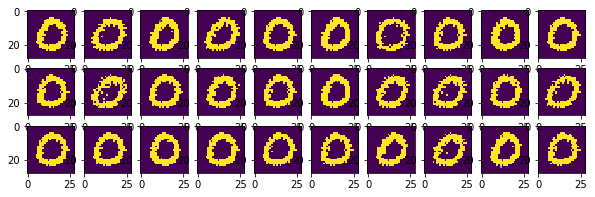

In [81]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128) * 1000 - 500
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.rand(img.shape[0], 128) * 1000 - 500
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################
    
    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())   
        
    if epoch%10 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()


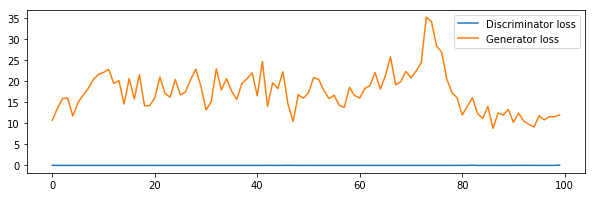

In [82]:
import matplotlib.pyplot as plt

plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.legend()
plt.show()

In [0]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128) * 1000 - 500
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.rand(img.shape[0], 128) * 1000 - 500
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################
    
    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())   
        
    if epoch%10 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()
